In [1]:
# import libraries
import numpy as np
import sys
import psi4
from helper_PFCI import PFHamiltonianGenerator
np.set_printoptions(threshold=sys.maxsize)
psi4.core.set_output_file('output.dat', False)
import matplotlib.pyplot as plt

We are going to read the energy eigenvalues and dipole matrix elements from .npy files.  We will also still create an instance of the PFHamiltonianGenerator class so we can use its build_pcqed_pf_hamiltonian() method, but it is not really important what details we use to instantiate this class... so we will use LiH in a minimal basis since this is a fast way to instantiate the class!

In [2]:
# read data from .npy files for formaldehyde casci(8,8) calculations

# !!! Change this to the correct path on your computer!
npy_folder = "/Users/jfoley19/Code/data_repository/NPY_Files/LiH/"

# these file names should still be good
E_npy_file = npy_folder + "LiH_r_1.4_6311g_fci_500_states_Energies.npy"
Mu_npy_file = npy_folder + "LiH_r_1.4_6311g_fci_500_states_Dipoles.npy"


# store energy eigenvalues in E_array
E_array = np.load(E_npy_file)
# store dipole matrix elements in Mu_array
Mu_array = np.load(Mu_npy_file)

print(np.shape(E_array))
print(np.shape(Mu_array))

# print their shape so we know how many elements we have
print(np.shape(E_array))
print(np.shape(Mu_array))


# setup basic arguments to create an instance of the PFHamiltonianGenerator class
mol_str = """
    Li
    H 1 1.4
    symmetry c1
"""


options_dict = {
    "basis": "sto-3g",
    "scf_type": "pk",
    "e_convergence": 1e-10,
    "d_convergence": 1e-10,
}


cavity_free_dict = {
    'omega_value' : 0.12086,
    'lambda_vector' : np.array([0, 0, 0.05]),
    'ci_level' : 'fci',   
    'full_diagonalization' : True,
    'number_of_photons' : 0, 
}

# create the instance of our PFHamiltonianGenerator class
instance = PFHamiltonianGenerator(mol_str, options_dict, cavity_free_dict)

(500,)
(500, 500, 3)
(500,)
(500, 500, 3)

Start SCF iterations:

Canonical RHF One-electron energy = -12.6946346236295895
CQED-RHF One-electron energy      = -12.6809948417115876
Nuclear repulsion energy          = 1.1339511657214287
Dipole energy                     = 0.0129085217276915
SCF Iteration   1: Energy = -7.8566740258646419   dE = -7.85667E+00   dRMS = 3.20530E-04
SCF Iteration   2: Energy = -7.8566790098824146   dE = -4.98402E-06   dRMS = 3.95666E-05
SCF Iteration   3: Energy = -7.8566791754252403   dE = -1.65543E-07   dRMS = 1.25930E-05
SCF Iteration   4: Energy = -7.8566792018488130   dE = -2.64236E-08   dRMS = 1.50801E-07
SCF Iteration   5: Energy = -7.8566792018491487   dE = -3.35731E-13   dRMS = 1.03800E-09
SCF Iteration   6: Energy = -7.8566792018491469   dE =  1.77636E-15   dRMS = 1.24962E-10
SCF Iteration   7: Energy = -7.8566792018491487   dE = -1.77636E-15   dRMS = 4.59316E-15
Total time for SCF iterations: 0.001 seconds 

QED-RHF   energy: -7.85667920 hartree
Ps

In [3]:
N_el = 500
N_ph = 10
omega = 0.12086
lambda_vector = np.array([0., 0., 0.2])


instance.fast_build_pcqed_pf_hamiltonian(N_el, N_ph, omega, lambda_vector , E_array, Mu_array)

In [4]:
d_uncoupled_gs = np.dot(lambda_vector, Mu_array[0,0,:])

#d_coupled_gs = np.copy(d_uncoupled_gs)
d_coupled_gs = np.dot( instance.PCQED_pf_vecs[:,0].conj().T, np.dot( instance.PCQED_MU, instance.PCQED_pf_vecs[:,0]))

print(d_uncoupled_gs)
print(d_coupled_gs)

dd = d_coupled_gs - d_uncoupled_gs
print(dd)

-0.4197345875989735
-0.42288458390653577
-0.003149996307562297


# Perturbation Theory for the Cavity:

$$ \hat{H} = \hat{H}_0 + \lambda \hat{H}' \tag{1} $$

where 

$$\hat{H}_0 = \frac{1}{2} \hat{p}^2 + \frac{1}{2}\omega^2 \hat{q}^2 \tag{2} $$

and 

$$ \hat{H}' = -\omega \hat{d} \hat{q} \tag{3} $$ 

where $\hat{d} = \lambda \cdot \hat{\mu}$, $\hat{p} = i \sqrt{\frac{\hbar \omega}{2}} (\hat{b}^{\dagger} - \hat{b} )$, and $\hat{q} =  \sqrt{\frac{\hbar}{2\omega}} (\hat{b}^{\dagger} + \hat{b} )$.  

Note that this perturbation is the bilinear coupling term, which is often written as 

$$ \hat{H}_{blc} = - \omega \hat{\mu} {\bf A}_0 (\hat{b}^{\dagger} + \hat{b}) \tag{4} $$

with ${\bf A}_0 = \sqrt{\frac{\hbar}{2\omega \epsilon_0 L^3}} \hat{e}$.  Here we have used the fact that $\lambda = \sqrt{\frac{1}{\epsilon_0 L^3}} $ to rewrite this term in the form shown in Eq. 3.


In [5]:
import numpy as np
from matplotlib import pyplot as plt
import numpy as np
from numpy import trapz
from scipy.special import hermite
from math import factorial
def compute_alpha(omega, hbar):
    """ Helper function to compute \alpha = \omega / \hbar
    
    Arguments
    ---------
    omega : float
        The photon frequency
        
    hbar : float
        reduced planck's constant
        
    Returns
    -------
    alpha : float
        \alpha = omega / hbar
    
    """
    # compute alpha
    alpha =  omega / hbar
    
    # return alpha
    return alpha

def N(n, alpha):
    """ Helper function to take the quantum number n of the Harmonic Oscillator and return the normalization constant
        
    Arguments
    ---------
    n : int
        the quantum state of the harmonic oscillator
        
    Returns
    -------
    N_n : float
        the normalization constant
    """
    
    return  np.sqrt( 1 / (2 ** n * factorial(n)) ) * ( alpha / np.pi ) ** (1/4) 

def psi(n, alpha, r, r_eq):
    """ Helper function to evaluate the Harmonic Oscillator energy eigenfunction for state n
        
    Arguments
    ---------
    n : int
        the quantum state of the harmonic oscillator
        
    alpha : float
        alpha value
        
    
    r : float
        position at which psi_n will be evaluated
        
    r_eq : float
        equilibrium bondlength
        
    Returns
    -------
    psi_n : float
        value of the harmonic oscillator energy eigenfunction
        
    """
    
    Hr = hermite(n)
    
    psi_n = N(n, alpha) * Hr( np.sqrt(alpha) * ( r - r_eq )) * np.exp( -0.5 * alpha  * (r - r_eq)**2)
    
    return psi_n

def harmonic_eigenvalue(n, omega, hbar):
    """ Helper function to evaluate the energy eigenvalue of the harmonic oscillator for state n"""
    
    return hbar * omega * (n + 1/2)


def potential_matrix_element(n, m, alpha, r, r_eq, V_p):
    """ Helper function to compute <n|V_p|m> where V_p is the perturbing potential
    
    Arguments
    ---------
    n : int
        quantum number of the bra state
        
    m : int
        quantum number of the ket state
        
    alpha : float
        alpha constant for bra/ket states
        
    r : float
        position grid for bra/ket states
        
    r_eq : float
        equilibrium bondlength for bra/ket states
        
    V_p : float
        potential array
        
    Returns
    -------
    V_nm : float
        <n | V_p | m > 
    
    """
    # bra 
    psi_n = psi(n, alpha, r, r_eq)
    
    # ket 
    psi_m = psi(m, alpha, r, r_eq)
    
    # integrand
    integrand = np.conj(psi_n) * V_p * psi_m
    
    # integrate
    V_nm = np.trapz(integrand, r)
    
    return V_nm

<>:8: SyntaxWarning: invalid escape sequence '\o'
<>:8: SyntaxWarning: invalid escape sequence '\o'
/var/folders/5f/ftf5xlgj4dv_6xxqh_p9pwyc0000gq/T/ipykernel_87978/2267568441.py:8: SyntaxWarning: invalid escape sequence '\o'
  """ Helper function to compute \alpha = \omega / \hbar


In [6]:

# equilibrium bondlength in Angstroms
r_eq_ang = 0

# atomic mass units to kg
amu_to_kg = 1.66054e-27

# angstroms to meters
ang_to_m = 1e-10

# electron volts to Jouls
eV_to_J = 1.60218e-19

# electron volts to atomic units of energy (Hartrees)
eV_to_au = 1 / 27.211 #0.0367493

# angstroms to atomic units of length (Bohr radii)
au_to_ang = 0.52917721067121

# atomic mass units to atomic units of mass 
amu_to_au = 1822.89


# array of bondlength values
r = np.linspace(-6, 6 , 200)

# equilibrium bondlength in SI
r_eq_au = r_eq_ang / au_to_ang


hbar_au = 1

alpha = compute_alpha(omega, hbar_au)
# compute psi_0 along the r grid


# h in SI
h_SI = np.pi * 2

def evaluate_Harmonic(r, omega, r_eq):
    """ Helper function to evaluate the Harmonic potential at a given value of r
    
    Arguments
    ---------
    r : float
        value(s) of r to evaluate potential at
        
    omega : float
        value of the frequency
        
    r_eq : float
        equilibrium position of oscillator
        
    Returns
    -------
    V_m : float
        value of the potential at r
    
    """
    return 1 / 2 * omega ** 2 * r ** 2




# array of Morse potential values



-11.498962302718317 4.501037697281683


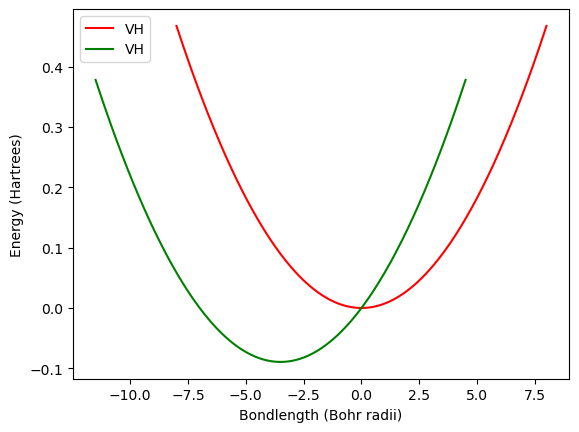

In [7]:
#from matplotlib import rc
#rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 14})
#rc('text', usetex=True)

#d_coupled_gs += d_uncoupled_gs #- d_coupled_gs
MIN_R = -8
MAX_R = 8
r = np.linspace(MIN_R, MAX_R , 200)
r_disp = np.linspace(MIN_R + d_coupled_gs/ omega, MAX_R + d_coupled_gs/ omega , 200)
#r_disp = np.linspace(MIN_R + dd/ omega, MAX_R + dd/ omega , 200)

psi_0 = psi(0, alpha, r, r_eq_au)

#psi_0_p = psi(0, alpha, r_disp, r_eq_au - d_coupled_gs)
psi_0_p = psi(0, alpha, r_disp, r_eq_au - dd)




print(r_disp[0], r_disp[199])
V_H = evaluate_Harmonic(r, omega, r_eq_au)
#perturb = -omega * d_coupled_gs * r

#V_H_p = 1 / 2 * ( omega * r_disp - d_coupled_gs + d_uncoupled_gs) ** 2  - 1 / 2 * d_coupled_gs ** 2
V_H_p = 1 / 2 * ( omega * r_disp - d_coupled_gs) ** 2  - 1 / 2 * d_coupled_gs ** 2
#evaluate_Harmonic(r - d_coupled_gs, omega, r_eq_au) - 1/2 * d_coupled_gs ** 2

E_0 = np.ones_like(V_H) * omega / 2
E_1 = np.ones_like(V_H) * 3 * omega / 2

#plt.plot(r, V_Morse, 'purple', label="Morse Potential")
plt.plot(r, V_H, 'red', label="VH")
plt.plot(r_disp, V_H_p, 'green', label="VH")
#plt.plot(r, V_H+perturb, 'turquoise', label="VH - d")
#plt.plot(r, E_0, 'b--', label="E_0")
#plt.plot(r, psi_0**2+E_0, 'darkgreen', label="psi_0")
#plt.xlim(-2, 2)
plt.xlabel("Bondlength (Bohr radii)")
plt.ylabel("Energy (Hartrees)")
plt.legend()
plt.show()

-0.010732454823351521
0.1021169902623682
0.015259367928050795


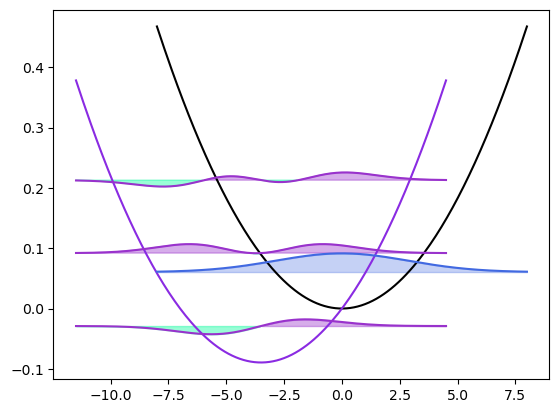

In [8]:
fig, ax = plt.subplots()

COLOUR1 = 'darkorchid'
COLOUR2 = 'mediumspringgreen'
COLOUR3 = 'royalblue' 
COLOUR4 = 'darkorchid' 



#(0.6196, 0.0039, 0.2588, 1.0)
#COLOUR2 = #(0.3686, 0.3098, 0.6353, 1.0)
QPAD_FRAC = 1.3
# Scale the wavefunctions by this much so they don't overlap
SCALING = 0.7

psi_0 = psi(0, alpha, r, r_eq_au)
#psi_1 = psi(1, alpha, r, r_eq_au)
#psi_2 = psi(2, alpha, r, r_eq_au)

#psi_0_p = psi(0, alpha, r, r_eq_au +  d_coupled_gs- d_uncoupled_gs)
#psi_1_p = psi(1, alpha, r, r_eq_au +  d_coupled_gs - d_uncoupled_gs)
#psi_2_p = psi(2, alpha, r, r_eq_au +  d_coupled_gs - d_uncoupled_gs)
psi_0_p = psi(0, alpha, r, r_eq_au +  d_coupled_gs)
psi_1_p = psi(1, alpha, r, r_eq_au +  d_coupled_gs)
psi_2_p = psi(2, alpha, r, r_eq_au +  d_coupled_gs)


prod_00 = -psi_0 * omega * d_coupled_gs * r * psi_0_p
prod_10 = -psi_0 * omega * d_coupled_gs * r * psi_1_p
prod_20 = -psi_0 * omega * d_coupled_gs * r * psi_2_p

print(np.trapz(prod_00, r))
print(np.trapz(prod_10, r))
print(np.trapz(prod_20, r))

def plot_func(ax, f, scaling=1, yoffset=0):
    """Plot f*scaling with offset yoffset.

    The curve above the offset is filled with COLOUR1; the curve below is
    filled with COLOUR2.

    """
    ax.plot(r, f*scaling + yoffset, color=COLOUR3)
    ax.fill_between(r, f*scaling + yoffset, yoffset, f > 0.,
                    color=COLOUR3, alpha=0.3)
    ax.fill_between(r, f*scaling + yoffset, yoffset, f < 0.,
                    color=COLOUR3, alpha=0.3)


def plot_func_offset(ax, f, scaling=1, yoffset=0):
    """Plot f*scaling with offset yoffset.

    The curve above the offset is filled with COLOUR1; the curve below is
    filled with COLOUR2.

    """
    ax.plot(r_disp, f*scaling + yoffset, color=COLOUR1)
    ax.fill_between(r_disp, f*scaling + yoffset, yoffset, f > 0.,
                    color=COLOUR1, alpha=0.4)
    ax.fill_between(r_disp, f*scaling + yoffset, yoffset, f < 0.,
                    color=COLOUR2, alpha=0.4)

def plot_prod_offset(ax, f, scaling=1, yoffset=0):
    """Plot f*scaling with offset yoffset.

    The curve above the offset is filled with COLOUR1; the curve below is
    filled with COLOUR2.

    """
    ax.plot(r_disp, f*scaling + yoffset, color=COLOUR1)
    ax.fill_between(r_disp, f*scaling + yoffset, yoffset, f > 0.,
                    color=COLOUR4, alpha=0.5)
    ax.fill_between(r_disp, f*scaling + yoffset, yoffset, f < 0.,
                    color=COLOUR4, alpha=0.5)
    
    
#psi_0**2+E_0
plt.plot(r, V_H, color='k', linewidth=1.5)
plt.plot(r_disp, V_H_p, color='blueviolet', linewidth=1.5)
plot_func(ax, psi_0, scaling=0.07, yoffset =  omega / 2)
#plot_func(ax, psi_1, scaling=0.07, yoffset =  3 * omega / 2)
#plot_func(ax, psi_2, scaling=0.07, yoffset =  5 * omega / 2)
#plot_func_offset(ax, psi_0_p, scaling=0.1, yoffset = omega / 2 - 1/2 * d_coupled_gs ** 2)
#plot_func_offset(ax, psi_0_p, scaling=0.1, yoffset = omega / 2 - 1/2 * d_coupled_gs ** 2)
#plot_func_offset(ax, psi_1_p, scaling=0.1, yoffset = 3 * omega / 2 - 1/2 * d_coupled_gs ** 2)
#plot_func_offset(ax, psi_2_p, scaling=0.1, yoffset = 5 * omega / 2 - 1/2 * d_coupled_gs ** 2)
plot_func_offset(ax, prod_00, scaling=1., yoffset = omega / 2 - 1/2 * d_coupled_gs ** 2)
plot_func_offset(ax, prod_10, scaling=1., yoffset = 3 * omega / 2 - 1/2 * d_coupled_gs ** 2)
plot_func_offset(ax, prod_20, scaling=1., yoffset = 5 * omega / 2 - 1/2 * d_coupled_gs ** 2)
#ax.plot(r, V_H, color='k', linewidth=1.5)
#plt.plot(r, V_H+perturb, color='green', linewidth=1.0)
plt.show()


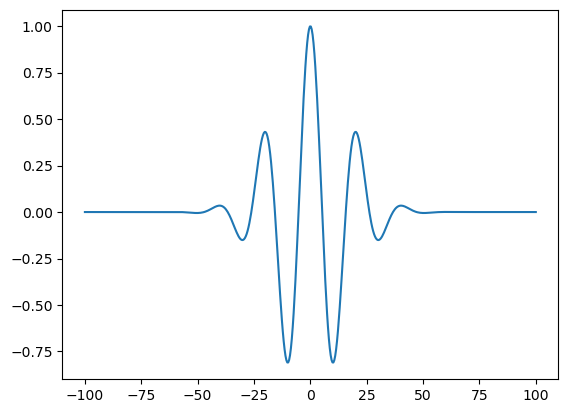

In [19]:
x = np.linspace(-100, 100, 500)
k = 0.3
sig = 0.002
ci = 0. + 1j

p = np.exp(-sig * x ** 2 ) * np.exp( ci * k * x)

plt.plot(x, p)
plt.show()